## Exploratory Data Analysis for Microsoft Film Studios

Authors: Alexander Claudino Daffara, Utku Kale

Blog post URLs: 

https://medium.com/@alexanderdaffara

https://medium.com/@utkukale


## Overview

Microsoft is launching a new film studio and using data analysis from sources like IMDb, The Numbers, and Kaggle to gain a deeper understanding of the film industry to maximize profits, visibility, and reception. The analysis will focus on identifying profitable genres, the impact of movie runtime, and the relationship between lead actor gender and box office success to inform their decision-making and strategy.

## Market and Business Understanding

Microsoft, a well-established tech company, is entering the film industry with the goal of creating successful and profitable films. It aims to ensure that its initial film releases are of the highest quality by analyzing film data from 2013-2019, which marks the beginning of the streaming services boom. The project will focus on key questions such as determining how much to spend on production to maximize profit, identifying profitable film genres and combinations of genres, and examining the impact of movie runtime, lead actor gender and how it affect profitability. 

By analyzing data from sources like IMDb, The Numbers, and Kaggle, the company aims to gain actionable insights that will inform their decision-making and strategy for the new film studio, thus increasing chances of a successful launch.

## Data

The Datasets we used are from IMDb, The Numbers and Kaggle

IMDb data contains information about the movie GENRES and RUNTIME in minutes

146k movies before data-cleaning for our analysis
The Numbers contains information about PRODUCTION BUDGET and REVENUE for the films

~5.5k movies before data-cleaning for our analysis
Kaggle's "The Movie Dataset" contains information about cast and ACTOR GENDER

~45k movies before data-cleaning for our analysis

### Imports
Using sqlite3 and pandas for data analysis and cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import warnings
warnings.filterwarnings(action='ignore')
%matplotlib inline

# DATA GATHERING

# IMDb

In [2]:
conn = sqlite3.connect('data/im.db')
cursor = conn.cursor()
movie_basics_df = pd.read_sql("""SELECT * FROM movie_basics """, conn)    # 146144  movie_id  (unique)
conn.close()

# Contains information about movie release years, runtime and genres
print("Number of movies:", movie_basics_df.shape[0])
movie_basics_df.head()

Number of movies: 146144


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


# The Numbers movie budgets

In [3]:
budgets_df = pd.read_csv('data/tn.movie_budgets.csv')
print("Number of movies:", budgets_df.shape[0])

# Contains information about movie release dates, production budget and gross values
budgets_df.head()

Number of movies: 5782


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


### Budget data cleaning

In [4]:
# convert dates and prices from strings to int 
budgets_df['production_budget'] = \
    budgets_df['production_budget'].map(lambda x: x.replace('$','').replace(',','')).astype(int)
budgets_df['domestic_gross'] = \
    budgets_df['domestic_gross'].map(lambda x: x.replace('$','').replace(',','')).astype(int)
budgets_df['worldwide_gross'] = \
    budgets_df['worldwide_gross'].map(lambda x: x.replace('$','').replace(',','')).astype('int64')

# release_year calculated from release date
budgets_df['release_year'] = budgets_df['release_date'].map(lambda x: x[-4:]).astype(int)
# profit column calculated from total gross and production budgets
budgets_df['profit'] = budgets_df['worldwide_gross'] - budgets_df['production_budget']

# drop unnecessary columns
budgets_df.drop(columns=['id', 'release_date'], inplace=True)

# drop rows with no worldwide gross
budgets_df = budgets_df.loc[budgets_df['worldwide_gross'] != 0]

# CONSIDER ONLY movies released AFTER 2013
budgets_df = budgets_df.loc[budgets_df['release_year'] >= 2013]
modern_budgets_df = budgets_df.copy()

# contains cleaned data on production budgets, profit, and release_year (only films after 2013)
print("Number of movies:", modern_budgets_df.shape[0])
modern_budgets_df.head()

Number of movies: 1216


,movie,production_budget,domestic_gross,worldwide_gross,release_year,profit
2,Dark Phoenix,350000000,42762350,149762350,2019,-200237650
3,Avengers: Age of Ultron,330600000,459005868,1403013963,2015,1072413963
4,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017,999721747
5,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,2015,1747311220
6,Avengers: Infinity War,300000000,678815482,2048134200,2018,1748134200


### Removing profit outliers
There are profit outlier in the data which would significantly skew our distributions, we've decided to remove them

In [5]:
# Outliers decided by values over 1.5*(inter quartile range)
modern_budgets_df = budgets_df.copy() # shape = (1216 x 8)
iqr = modern_budgets_df['profit'].quantile(.75) - modern_budgets_df['profit'].quantile(.25)
upper_bound = modern_budgets_df.profit.mean() + 1.5 * iqr
lower_bound = modern_budgets_df.profit.mean() - 1.5 * iqr

# THIS WILL SET MODERN BUDGETS TO EXCLUDE 150/1216 PROFIT OUTLIERS
modern_budgets_df = modern_budgets_df.loc[(modern_budgets_df.profit < upper_bound) & \
                                          (modern_budgets_df.profit > lower_bound)]

# Contains information about movie release years, runtime and genres
print("Number of movies:", modern_budgets_df.shape[0])
modern_budgets_df.head()

Number of movies: 1063


,movie,production_budget,domestic_gross,worldwide_gross,release_year,profit
11,Solo: A Star Wars Story,275000000,213767512,393151347,2018,118151347
12,The Lone Ranger,275000000,89302115,260002115,2013,-14997885
64,The Mummy,195000000,80101125,409953905,2017,214953905
65,Jack the Giant Slayer,195000000,65187603,197687603,2013,2687603
69,The Great Gatsby,190000000,144840419,351040419,2013,161040419


# Insight 1: 
### Spend More to earn more. Risk of loss is reduced especially above 50 million in production budget.



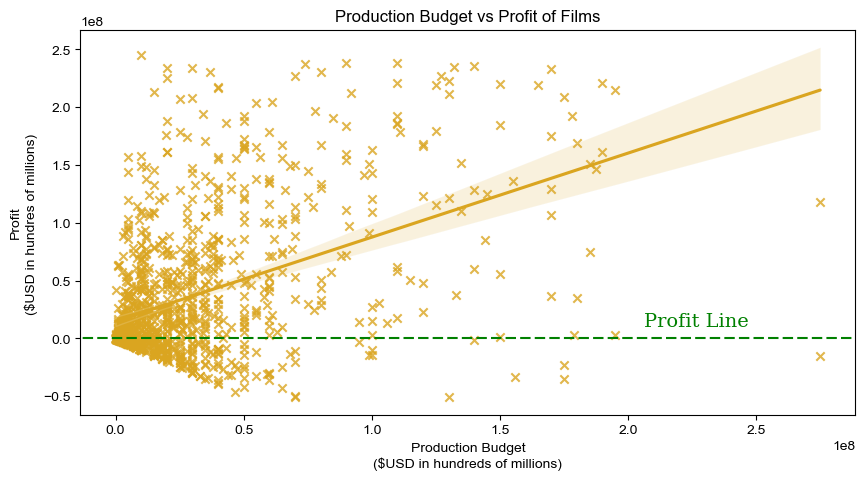

Pearson Correlation: 0.7777708411019403


In [6]:
# Set up figure and axes
fig, ax = plt.subplots(figsize=(10,5))

# Set dark seaborn plotting style with gridlines
sns.set_style('whitegrid')
sns.regplot(x='production_budget',
            y='profit',
            data=modern_budgets_df,
            scatter=True,
            color='goldenrod',
            marker='x',
            ax=ax)

# set profit line at profit = 0
plt.axhline(0,modern_budgets_df.production_budget.max(),0, color='green', dashes=[5,2])

# Text to label the profit line in the adxes
ax.text(modern_budgets_df.production_budget.max()*.75, 
        10000000,
        'Profit Line', 
        fontdict={'family': 'serif',
                  'color':  'Green',
                  'weight': 'normal',
                  'size': 14,
                  })
# setting axes labels and title
ax.set_xlabel('Production Budget\n($USD in hundreds of millions)')
ax.set_ylabel('Profit\n($USD in hundres of millions) ')
ax.set(title='Production Budget vs Profit of Films')
plt.show()

# show pearson correlation
print("Pearson Correlation:", modern_budgets_df.corr()['production_budget']['worldwide_gross'])

# Insight 2:
### Choose from one of the top 5 profitable genres.

We made the decision to include only genre combinations with at least 40 samples as to not allow genres with few samples dominate the profit average. This makes the distribution more representative of our population. Each genre bin represents a sample of movies containing at least that genre or genre combination. In example: "Adventure & Comedy", representing the highest average profit, contains all films that are both adventure and comedy, as well as films that are action, comedy and some other genre. A key insight to be taken from this chart is genre upscaling. For example, if Microsoft feels comfortable making a successful comedy movie, we would recommend you make an adventure & comedy movie to almost double your expected profit.

In [7]:
# temporary "cleaned_imdb_df" selects only the relevant columns and drops all rows with genres=N/a
cleaned_imdb_df = movie_basics_df.dropna(subset=['genres'])[['movie_id',
                                                            'primary_title',
                                                            'start_year',
                                                            'genres']]

# convert genres column from strings to tuples of the genres
cleaned_imdb_df['genres'] = cleaned_imdb_df['genres'].map(lambda x: tuple(x.split(',')))

# combined profit data from modern_budgets_df with genre data from imdb
profit_genreTuples_df = modern_budgets_df.merge(cleaned_imdb_df,
                                                how='inner',
                                                left_on=['movie',
                                                         'release_year'],
                                                right_on=['primary_title', 
                                                          'start_year'])[['movie',
                                                                          'release_year',
                                                                          'profit',
                                                                          'genres']]
print('profit_genreTuples_df before permuting genres:\n')
profit_genreTuples_df.head()

profit_genreTuples_df before permuting genres:



,movie,release_year,profit,genres
0,Solo: A Star Wars Story,2018,118151347,"(Action, Adventure, Fantasy)"
1,The Lone Ranger,2013,-14997885,"(Action, Adventure, Western)"
2,The Mummy,2017,214953905,"(Action, Adventure, Fantasy)"
3,Jack the Giant Slayer,2013,2687603,"(Adventure, Fantasy)"
4,The Great Gatsby,2013,161040419,"(Drama, Romance)"


### Creating Powerset genres dataframe
For our genre analysis we created a new version of the IMDb dataframe where new rows are appended according to the powerset (exluding the empty set) of the genres.

In [8]:
# A movie with multiple multiple genres:
example_df = \
movie_basics_df.loc[movie_basics_df['primary_title'] == 'Solo: A Star Wars Story'][['primary_title', 'genres']]
example_df

,primary_title,genres
66299,Solo: A Star Wars Story,"Action,Adventure,Fantasy"


In [9]:
# The new dataframe will have all subsets of that list of genres appended as new rows
example_df = example_df.append({'primary_title':'Solo: A Star Wars Story', 'genres':'Action,Adventure'}, 
                               ignore_index=True)
example_df = example_df.append({'primary_title':'Solo: A Star Wars Story', 'genres':'Action,Fantasy'}, 
                               ignore_index=True)
example_df = example_df.append({'primary_title':'Solo: A Star Wars Story', 'genres':'Adventure,Fantasy'}, 
                               ignore_index=True)
example_df = example_df.append({'primary_title':'Solo: A Star Wars Story', 'genres':'Action'}, 
                               ignore_index=True)
example_df = example_df.append({'primary_title':'Solo: A Star Wars Story', 'genres':'Adventure'}, 
                               ignore_index=True)
example_df = example_df.append({'primary_title':'Solo: A Star Wars Story', 'genres':'Fantasy'}, 
                               ignore_index=True)
example_df

,primary_title,genres
0,Solo: A Star Wars Story,"Action,Adventure,Fantasy"
1,Solo: A Star Wars Story,"Action,Adventure"
2,Solo: A Star Wars Story,"Action,Fantasy"
3,Solo: A Star Wars Story,"Adventure,Fantasy"
4,Solo: A Star Wars Story,Action
5,Solo: A Star Wars Story,Adventure
6,Solo: A Star Wars Story,Fantasy


Hence, In this new dataframe, the genre column indicates that the movie has AT LEAST the given genre/combination of genres

In [10]:
# exploded is a copy of profit_genreTuples_df with each "genres" element of profit_genreTuples_df to a row, 
# replicating index values.
exploded_df = profit_genreTuples_df.explode('genres')

# Appending to profit_genreTuples_df the powerset of rows with 2 and 3 genres
for i in profit_genreTuples_df.index:
    row = profit_genreTuples_df.loc[i]
        
    genres = row['genres']
    if len(genres) == 3:
        new_row = {col:row[col] for col in row.index.to_list()}

        # genres[0,1]
        new_row['genres'] = (genres[0],genres[1])
        profit_genreTuples_df = profit_genreTuples_df.append(new_row, ignore_index=True)
        
        # genres[0,2]
        new_row['genres'] = (genres[0],genres[2])
        profit_genreTuples_df = profit_genreTuples_df.append(new_row, ignore_index=True)
        
        # genres[1,2]
        new_row['genres'] = (genres[1],genres[2])
        profit_genreTuples_df = profit_genreTuples_df.append(new_row, ignore_index=True)

# three_and_two_grams only has rows from profit_genreTuples_df with multiple genres
three_and_two_grams = \
    profit_genreTuples_df.loc[profit_genreTuples_df['genres'].map(lambda x: \
                                                                  True if len(x) >= 2 else False)]

# for some reason exploded has duplicates
profit_genreTuples_df = pd.concat([three_and_two_grams,exploded_df]).drop_duplicates()

# profit_genreTuples_df has genres tuples for each film split (exploded) into multiple rows
profit_genreTuples_df

,movie,release_year,profit,genres
0,Solo: A Star Wars Story,2018,118151347,"(Action, Adventure, Fantasy)"
1,The Lone Ranger,2013,-14997885,"(Action, Adventure, Western)"
2,The Mummy,2017,214953905,"(Action, Adventure, Fantasy)"
3,Jack the Giant Slayer,2013,2687603,"(Adventure, Fantasy)"
4,The Great Gatsby,2013,161040419,"(Drama, Romance)"
...,...,...,...,...
786,Counting,2015,-41626,Documentary
787,Emily,2017,-23453,Drama
788,Exeter,2015,464792,Horror
788,Exeter,2015,464792,Mystery


In [11]:
""" FOR LABELLING GENRE PLOT X Tick Labels, ugly = tuple, returns pretty string"""
def get_pretty_labels(ugly):
    labels = []
    for genre in ugly:
        if type(genre) == tuple:
            if len(genre) == 3:
                labels.append('{}, {} & {}'.format(genre[0],genre[1],genre[2]))
            if len(genre) == 2:
                labels.append('{} & {}'.format(genre[0],genre[1]))
        else:
            labels.append(genre)
    return labels

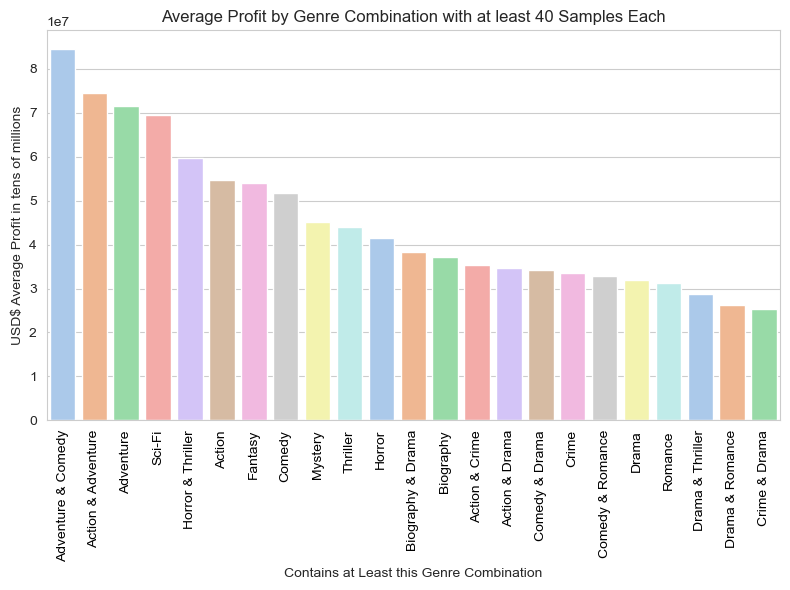

In [12]:
# DATA FOR PROFIT PER GENRETUPLES WITH AT LEAST n SAMPLES EACH
num_samples_per_genre_tuple = 40

# groupby data of genres, aggregated by mean and sorted highest to lowest by profit
grouped_tuples_df = profit_genreTuples_df.groupby('genres').mean().sort_values(by='profit', ascending=False)

# remove rows with genres that have less than 40 sample counts
grouped_tuple_count_df = profit_genreTuples_df.groupby('genres').count()
grouped_tuple_count_df = \
    grouped_tuple_count_df.loc[grouped_tuple_count_df['profit'] > num_samples_per_genre_tuple]
tuple_profit_40samples_df = \
    grouped_tuples_df.join(grouped_tuple_count_df, 
                           how='inner', 
                           rsuffix='_count').sort_values(by='profit', ascending=False)

fig, ax = plt.subplots(figsize=(8,6))

# get pretty labels for genres
xlabels = get_pretty_labels(tuple_profit_40samples_df.index)
data = tuple_profit_40samples_df
# bar plot genres by average profit descending
sns.barplot(x=data.index,
            y='profit',
            data=data,
            errwidth=0,
            palette='pastel',
            ax=ax)

# Set axes labels and title
ax.set_title('Average Profit by Genre Combination with at least {} \
    Samples Each'.format(num_samples_per_genre_tuple))
ax.set_xlabel('Contains at Least this Genre Combination')
ax.set_ylabel('USD$ Average Profit in tens of millions')

# set genre labels rotated on x axis
ax.set_xticklabels(xlabels, rotation=90, color='black')
fig.tight_layout()
plt.show()


### Original production budget vs. profit visualization, now showing the top genre

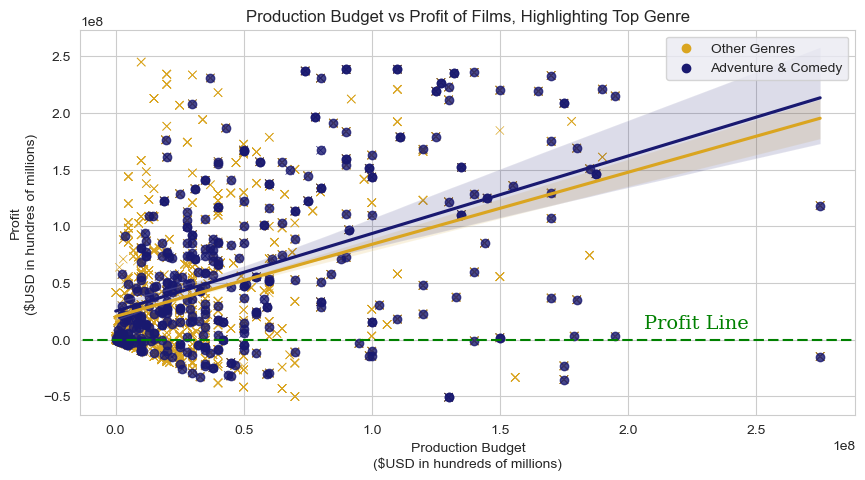

In [13]:
# cost_v_profit_df has ['movie','release_year','genres' (optimized),'production_budget','profit']

cost_v_profit_df = profit_genreTuples_df.merge(modern_budgets_df[['movie','release_year','production_budget']],
                                               how='inner',
                                               left_on=['movie', 'release_year'],
                                               right_on=['movie','release_year'],
                                               suffixes=['_',''])
# variable for the top genre combination found in previous graph
top_genre = tuple_profit_40samples_df.index[0]

# top_loc is a ordered list of booleans, mapping True for rows in cost_v_profit that are the top genre else False
top_loc = cost_v_profit_df['genres'].map(lambda x: True if x in top_genre else False)
# cost_v_profit_df now has a column 'is_top_genre', True if genre = (Adventure,Comedy) else False
cost_v_profit_df['is_top_genre'] = top_loc.map(lambda x: 'Adventure & Comedy' if x else 'Other Genres')


fig, ax = plt.subplots(figsize=(10,5))

# Original Cost v Profit scatter plot from insight 1
data = cost_v_profit_df
sns.scatterplot(x='production_budget',
                y='profit',
                hue='is_top_genre',
                legend='auto',
                data=data,
                palette=['goldenrod','midnightblue'],
                marker='x',
                ax=ax)

# regression line for all movies that are not the top genre
data = cost_v_profit_df.loc[~top_loc]
sns.regplot(x='production_budget',
            y='profit',
            scatter=False,
            color='goldenrod',
            data=data,
            ax=ax)

# regression line and scatter points colored for all movies that ARE the top genre
data = cost_v_profit_df.loc[top_loc]
sns.regplot(x='production_budget',
            y='profit',
            scatter=True,
            color='midnightblue',
            data=data,
            ax=ax)

# plotting reference lines and text
plt.plot(range(0,-50000000))
plt.axhline(0,modern_budgets_df.production_budget.max(),0, color='green', dashes=[5,2])

ax.text(modern_budgets_df.production_budget.max()*.75,10000000,'Profit Line', fontdict={'family': 'serif',
                                                                                        'color':  'Green',
                                                                                        'weight': 'normal',
                                                                                        'size': 14,
                                                                                        })

# setting axes labels and title
ax.set_xlabel('Production Budget\n($USD in hundreds of millions)')
ax.set_ylabel('Profit\n($USD in hundres of millions) ')
ax.set(title='Production Budget vs Profit of Films, Highlighting Top Genre')
sns.set_style('dark')
ax.legend(title='')
plt.show()

# Insight 3: 
### Choose an appropriate runtime length, given a choice of genre
This visualization shows the distribution of movie runtime lengths for each of our top 5 genres. From this we can choose a runtime length that is appropriate for each genre since the distributions (except for 'Adventure') are all heavily skewed towards one clear choice. Since we are choosing from proven profitable genres over the years, it is safe to assume that we want to emulate those common runtime choices.

In [14]:
# runtime_df has runtime info from IMDb with N/a values and outliers (over 200 min) dropped
runtime_df = movie_basics_df.dropna(subset=['runtime_minutes'])
runtime_df = runtime_df.loc[runtime_df['runtime_minutes'] < 200]

# combining clean runtime info with modern budget info
profit_runtime_df = modern_budgets_df.merge(runtime_df[['primary_title','start_year','runtime_minutes']],
                                            how='inner',
                                            left_on=['movie','release_year'],
                                            right_on=['primary_title','start_year'])
'''
param int x: runtime in minutes,
Returns: 
    'short' if x in lower third of runtime distribution
    'medium' if x in middle third of runtime distribution
    'long' if x in upper third of runtime distribution
'''
def get_length(x):
    short_bound = profit_runtime_df['runtime_minutes'].quantile(.33)
    long_bound = profit_runtime_df['runtime_minutes'].quantile(.66)
    if x < short_bound:
        return 'short'
    if x < long_bound:
        return 'medium'
    else:
        return 'long'
    
# set new 'length' column to associate runtimes to short, medium, long buckets
profit_runtime_df['length'] = profit_runtime_df['runtime_minutes'].map(get_length)
# sort profit_runtime_df by profit descending
profit_runtime_df.sort_values(by='profit', ascending=False, inplace=True)
profit_runtime_df.head()


,movie,production_budget,domestic_gross,worldwide_gross,release_year,profit,primary_title,start_year,runtime_minutes,length
529,Halloween,10000000,159342015,254900667,2018,244900667,Halloween,2018,106.0,medium
53,The Smurfs 2,110000000,71017784,348547523,2013,238547523,The Smurfs 2,2013,105.0,medium
78,Now You See Me 2,90000000,65075540,328325007,2016,238325007,Now You See Me 2,2016,129.0,long
94,The SpongeBob Movie: Sponge Out of Water,74000000,162994032,311013181,2015,237013181,The SpongeBob Movie: Sponge Out of Water,2015,92.0,short
30,G.I. Joe: Retaliation,140000000,122523060,375740705,2013,235740705,G.I. Joe: Retaliation,2013,110.0,medium


### Runtime Distribution per top 5 Genres

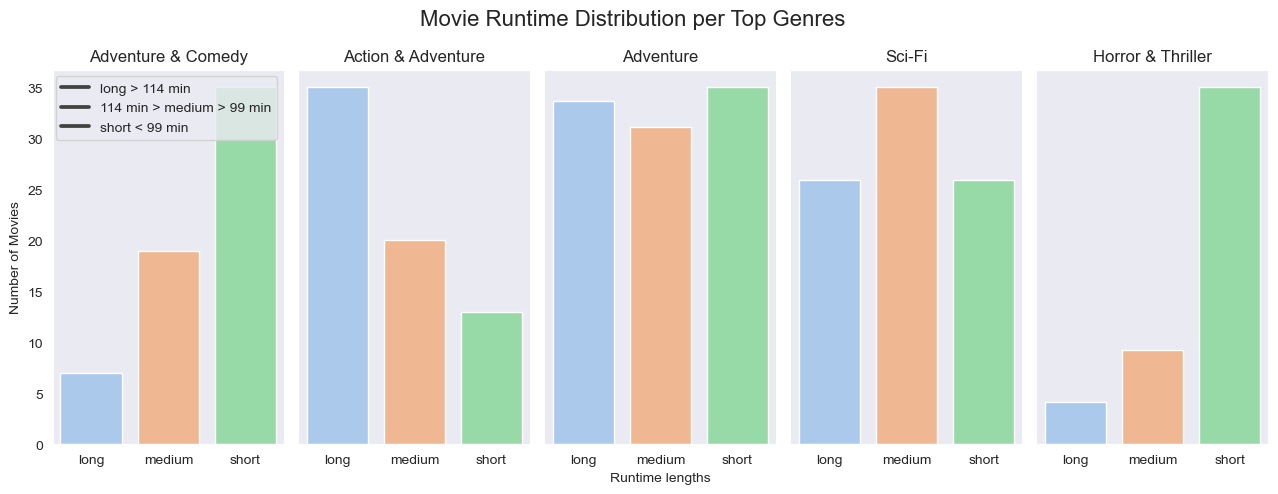

In [15]:
# list top 5 genres
top5_genre_combos = tuple_profit_40samples_df.index.to_list()[:5]
# create new df with only relevant columns
profit_runtime_truncated_df = profit_runtime_df[['movie','release_year','profit','runtime_minutes','length']]
# get only rows in top 5 genres
profit_genreTuples_genre_mapped_df = \
    profit_genreTuples_df.loc[profit_genreTuples_df['genres'].map(lambda x: True if x in top5_genre_combos \
                                                                            else False)]
# combine runtime and genre info into one df with only top 5 genre movies
genre_length_dirty_df = profit_runtime_truncated_df.merge(profit_genreTuples_genre_mapped_df, 
                                                        how='inner', 
                                                        on=['movie','release_year'], 
                                                        suffixes=['_l','_r'])

# list of 5 dataframes, each contains only movies from one of the 5 top 5 genres
genre_length_dfs = [genre_length_dirty_df.loc[genre_length_dirty_df['genres'] == genre] \
                    for genre in top5_genre_combos]


fig, ax = plt.subplots(ncols=5, figsize=(13,5))
sns.set_style('dark')
# turn genres from tuples to pretty strings for title
titles = get_pretty_labels(top5_genre_combos)
# loop through dataframes in genre_length_dfs list, and barplot the distribution of runtimes
for i, df in enumerate(genre_length_dfs):
    grouped = df.groupby('length').count()
    sns.barplot(x=grouped.index.to_list(), 
                y=grouped['movie'], 
                palette='pastel',
                ax=ax[i]).set(title=str(titles[i]))
    ax[i].set_ylabel('')
    ax[i].get_yaxis().set_visible(False)
    
    # dont remove the left most plot's spines
    if i != 0: ax[i].spines[['right', 'left']].set_visible(False)
# adjust spines
ax[0].spines[['right']].set_visible(False)
ax[len(titles)-1].spines[['right']].set_visible(True)
ax[0].get_yaxis().set_visible(True)
ax[0].set_ylabel('Number of Movies')
ax[len(titles)//2].set_xlabel('Runtime lengths')

# set Legend to explain runtime buckets
ax[0].legend(['long > 114 min','114 min > medium > 99 min','short < 99 min'])

# set overarching title
fig.suptitle('Movie Runtime Distribution per Top Genres', fontsize=16)


plt.tight_layout()
plt.show()

# Insight 4: 
### Given a choice of actor in a movie's leading role, some genres are more profitable than others, depending on the actor's gender. Conversely, given a choice of genre, we can conclude a lead actor gender which is statistically more profitable.

The Male distribution was sampled to have an equal sample population as the Female distribution, so we may compare them without the risk of mean inflation.

By analyzing the mean and bulge distribution of these probability density functions, we can make decisions such as:

If we have a specific female actress in mind, a Horror & Thriller is the most profitable choice

If we have a specific male actor in mind, the most profitable genre combination to go with is Action & Comedy - If we are comfortable making a Horror & Thriller movie, a Female actress is the best choice

Finally, the profit averages for males is very slightly higher than the profit averages for females. That being said, Microsoft is a highly influential company and have an opportunity to partake in building gender equality in the film industry for little net cost.

### Importing lead cast gender info from Kaggle's The Movies Dataset

In [16]:
credits_df = pd.read_csv('data/kaggle_data/credits.csv')
credits_df.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


### cleaning credits_df

In [17]:
# convert 'cast' column values from string to list of dictionaries
credits_df['cast'] = credits_df['cast'].map(lambda x: eval(x))
# drop nan cast rows
credits_df.drop(index=credits_df.loc[credits_df['cast'].map(lambda x: len(x) == 0)].index, inplace=True)

# sort the movie list by role (order), and get the movies leading cast gender, male=2 female=1
def get_lead_gender(movie):
    gender_id = sorted(movie, key=lambda x: x['order'])[0]['gender']
    # if gender = 0, return 0
    if not gender_id: return gender_id
    return 'Male' if gender_id == 2 else 'Female'

# sort the movie list by role (order), and get the movies leading cast name
def get_lead_name(movie):
    return sorted(movie, key=lambda x: x['order'])[0]['name']

# create columns 'cast_lead_name' and 'cast_lead_gender'
credits_df['cast_lead_gender'] = credits_df['cast'].map(get_lead_gender)
credits_df['cast_lead_name'] = credits_df['cast'].map(get_lead_name)

# drop duplicated rows and lossy gender info (gender = 0)
credits_df.drop(credits_df.loc[credits_df['cast_lead_gender'] == 0].index, inplace=True)
credits_df.drop(index=credits_df.loc[credits_df['id'].duplicated()].index, inplace=True)
credits_df.head()

,cast,crew,id,cast_lead_gender,cast_lead_name
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,Male,Tom Hanks
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,Male,Robin Williams
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,Male,Walter Matthau
3,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357,Female,Whitney Houston
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862,Male,Steve Martin


### Importing movie title and year info from Kaggle's The Movies Dataset

In [18]:
meta_data_df = pd.read_csv('data/kaggle_data/movies_metadata.csv')
# get only relevant columns
meta_data_df = meta_data_df[['id',
                             'imdb_id',
                             'title',
                             'release_date',
                             'revenue',
                             'runtime',
                             'vote_average',
                             'vote_count']]

# drop 3 "noisy" rows with id values that are dates
meta_data_df.drop(index=meta_data_df.loc[~meta_data_df['id'].str.isnumeric()].index, inplace=True)

# set id column values to int
meta_data_df['id'] = meta_data_df['id'].astype(int)

# drop druplicate id's
meta_data_df.drop(index=meta_data_df.loc[meta_data_df['id'].duplicated()].index, inplace=True)

# drop movies pre 2013
meta_data_df.dropna(subset=['release_date'], inplace=True)
meta_data_df['release_date'] = meta_data_df['release_date'].map(lambda x: x[:4]).astype(int)
meta_data_df.drop(index=meta_data_df.loc[meta_data_df['release_date'] < 2013].index, inplace=True)
meta_data_df.head()

,id,imdb_id,title,release_date,revenue,runtime,vote_average,vote_count
1081,141210,tt2250194,The Sleepover,2013,0.0,6.0,8.0,1.0
4356,110428,tt2018086,Camille Claudel 1915,2013,115860.0,95.0,7.0,20.0
11251,171771,tt2449612,The Scar,2013,0.0,90.0,0.0,0.0
14765,31156,tt1472122,Dante's Hell Animated,2013,0.0,35.0,8.0,4.0
18082,157924,tt2806964,Pompeii: The Mystery of the People Frozen in Time,2013,0.0,59.0,4.5,2.0


### Combining meta_data_df and credits_df by 'id'


In [19]:
kaggle_cleaned_df = meta_data_df.merge(credits_df[['id','cast_lead_name','cast_lead_gender']],
                                       how='inner',
                                       on='id')
kaggle_cleaned_df.head()

,id,imdb_id,title,release_date,revenue,runtime,vote_average,vote_count,cast_lead_name,cast_lead_gender
0,110428,tt2018086,Camille Claudel 1915,2013,115860.0,95.0,7.0,20.0,Juliette Binoche,Female
1,171771,tt2449612,The Scar,2013,0.0,90.0,0.0,0.0,Marc Béland,Male
2,31156,tt1472122,Dante's Hell Animated,2013,0.0,35.0,8.0,4.0,Jeff Conaway,Male
3,70074,tt1308729,Bullet to the Head,2013,9489829.0,92.0,5.2,490.0,Sylvester Stallone,Male
4,155288,tt1830495,Bela Kiss: Prologue,2013,0.0,106.0,4.4,4.0,Kristina Klebe,Female


In [20]:
# gender_profit_genre_df contains -> cast lead gender, profit and genre for all films in top5 genres
# *Equal Number of male and female movies:
#   - Films with male lead actors are sampled to equal the population size of female movies
gender_profit_genre_df = kaggle_cleaned_df[['title','release_date','revenue','cast_lead_gender']]
gender_profit_genre_df = gender_profit_genre_df.merge(profit_genreTuples_df[['movie',
                                                                             'release_year',
                                                                             'profit',
                                                                             'genres']],
                                                      how='inner',
                                                      left_on=['title','release_date'],
                                                      right_on=['movie','release_year'],
                                                      suffixes=['_l','_r'])
genre_loc = gender_profit_genre_df['genres'].map(lambda x: x in top5_genre_combos)
gender_profit_genre_df = gender_profit_genre_df.loc[genre_loc]
gender_profit_genre_df['genres'] = gender_profit_genre_df['genres'].astype(str)
display(gender_profit_genre_df.head())
gender_profit_genre_df['cast_lead_gender'].value_counts()

,title,release_date,revenue,cast_lead_gender,movie,release_year,profit,genres
13,Texas Chainsaw 3D,2013,47241945.0,Female,Texas Chainsaw 3D,2013,27666013,"('Horror', 'Thriller')"
29,Mama,2013,146497771.0,Female,Mama,2013,133095566,"('Horror', 'Thriller')"
58,The East,2013,2401510.0,Female,The East,2013,-3472044,Adventure
69,Identity Thief,2013,173965010.0,Male,Identity Thief,2013,140361578,"('Adventure', 'Comedy')"
72,Identity Thief,2013,173965010.0,Male,Identity Thief,2013,140361578,Adventure


Male      193
Female     58
Name: cast_lead_gender, dtype: int64

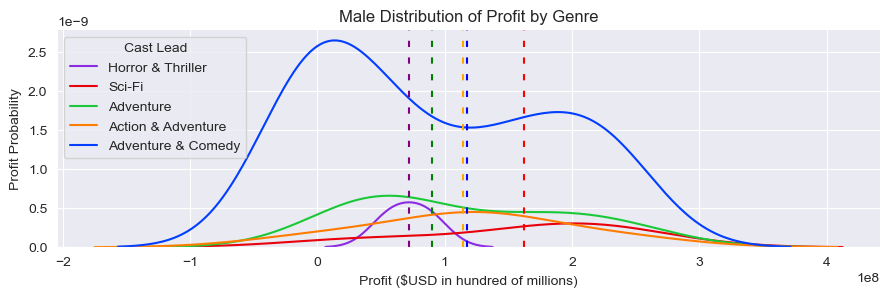

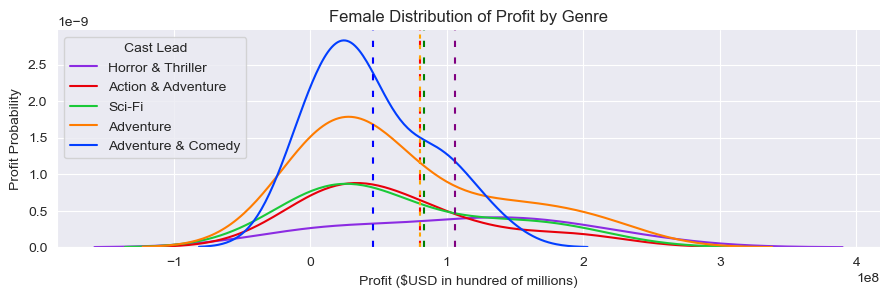

In [28]:
"""
* There sometimes are bugs with the Male distribution Legend, 
may need to run this cell a couple of times to show all legend labels *
"""

# sampling male lead actor movies to equal the population size of female movies
female_data = gender_profit_genre_df.loc[gender_profit_genre_df['cast_lead_gender'] == 'Female']
male_data   = gender_profit_genre_df.loc[gender_profit_genre_df['cast_lead_gender'] == 'Male']
male_data['weights'] = male_data['genres'].map(lambda x: male_data.groupby('genres').count()['title'].loc[x])
male_data_ = male_data.copy()
male_data = male_data_.sample(female_data.shape[0], weights='weights')

# repeat sampling until all genres are represented (unfortunately had to do this since sample size was low).
while((len(male_data['genres'].unique()) < 5) and \
      (len(male_data.loc[male_data['genres']==str(top5_genre_combos[-1])]) < 2)):
    male_data = male_data_.sample(female_data.shape[0], weights='weights')

# Set dark plot Style with gridlines
sns.set_style('darkgrid')

# plotting Male Distribution of Profit by Genre
data = male_data
column_name = 'profit'
ax = sns.displot(x = column_name, 
                 data=data, 
                 hue='genres',
                 palette='bright', 
                 kind='kde', 
                 legend=False,
                 height=3,
                 aspect=3).set(title='Male Distribution of Profit by Genre',
                                 xlabel='Profit ($USD in hundred of millions)',
                                 ylabel='Profit Probability')

# pl = ['Adventure & Comedy','Action & Adventure','Adventure','Sci-Fi','Horror & Thriller']
pl = get_pretty_labels(top5_genre_combos)
plt.legend(title='Cast Lead', loc='upper left', labels=[pl[4],pl[3],pl[2],pl[1],pl[0]])

#plotting Male mean lines
g = male_data.groupby('genres').mean()
idx = g.index
x = g.loc[idx[0]]['profit']
plt.axvline(x,0,200, color='orange', dashes=[3,5]) #Action

x = g.loc[idx[1]]['profit']
plt.axvline(x,0,200, color='blue', dashes=[3,5]) # comedy

x = g.loc[idx[2]]['profit']
plt.axvline(x,0,200, color='purple', dashes=[3,5]) # horror

x = g.loc[idx[3]]['profit']
plt.axvline(x,0,200, color='green', dashes=[3,5]) #adventure

x = g.loc[idx[4]]['profit']
plt.axvline(x,0,200, color='red', dashes=[3,5]) #scifi


# plotting Female Distribution of Profit by Genre
data = female_data
column_name = 'profit'
sns.displot(x = column_name, 
            data=data, 
            hue='genres', 
            palette='bright', 
            kind='kde', 
            legend=False,
            height=3,
            aspect=3).set(title='Female Distribution of Profit by Genre',
                                 xlabel='Profit ($USD in hundred of millions)',
                                 ylabel='Profit Probability')

#plotting Female mean lines
g = gender_profit_genre_df.groupby('genres').mean()
idx = g.index

x = g.loc[idx[0]]['profit']
plt.axvline(x,0,200, color='red', dashes=[3,5])

x = g.loc[idx[1]]['profit']
plt.axvline(x,0,200, color='purple', dashes=[3,5])

x = g.loc[idx[2]]['profit']
plt.axvline(x,0,200, color='blue', dashes=[3,5])

x = g.loc[idx[3]]['profit']
plt.axvline(x,0,200, color='orange', dashes=[2,3])

x = g.loc[idx[4]]['profit']
plt.axvline(x,0,200, color='green', dashes=[3,5])


# ['Adventure & Comedy','Action & Adventure','Adventure','Sci-Fi','Horror & Thriller']
pl = get_pretty_labels(top5_genre_combos)
plt.legend(title='Cast Lead', loc='upper left', labels=[pl[4],pl[1],pl[3],pl[2],pl[0]])



plt.show()

# Conclusion

TL;DR. These are the data driven suggestions we point out:

Spend more than 50 million to reduce the risk of loss, as the average high budget film will make more money than la ow budget film
Choose from one of these most profitable genre combinations, movie runtimes and lead actor gender (keeping in mind gender only slightly affects profit): Option 1: Genre -> Adventure & Comedy Runtime -> short (85 - 99 minutes) Leading Role Gender -> Male Option 2: Genre -> Action Adventure Runtime -> long (114 - 125 minutes) Leading Role Gender -> Male Option 3: Genre -> Adventure Runtime -> any (85 - 125 minutes) Leading Role Gender -> Male Option 4: Genre -> Sci-Fi Runtime -> medium (99 - 114 minutes) Leading Role Gender -> Male Option 5: Genre -> Horror Thriller Runtime -> short (85 - 99 minutes) Leading Role Gender -> Female
With our data analysis we have suggested actionable insights to ensure success for Microsft Studio's launch.

# Future Improvements

Adjust profit values with inflation over the years

Work with streaming service dataset to incorporate valuable recent data

Require more data for analysis, so we may have sample sizes that better represent the population, especially for our gender analysis, which is a highly discussed topic and there is high demand for accurate data